# Cycle GAN 구현

참조
- https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/models.py
- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/tree/master/models

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.cuda import is_available
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import os
from os import listdir
from os.path import join

In [2]:
torch.manual_seed(0)
device='cuda' if is_available() else 'cpu'

## Generator

Cycle GAN에선 residual block을 사용하여 generator를 만들었다.

In [3]:
class ResNetBlk(nn.Module):
  def __init__(self,dim):
    super(ResNetBlk, self).__init__()
    self.conv_block = self.build_blk(dim)
  def build_blk(self,dim):
    layers = []
    layers.append(nn.ReflectionPad2d(1))
    layers.append(nn.Conv2d(dim,dim,3,bias=False))
    layers.append(nn.InstanceNorm2d(dim))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.ReflectionPad2d(1))
    layers.append(nn.Conv2d(dim,dim,3,bias=False))
    layers.append(nn.InstanceNorm2d(dim))
    return nn.Sequential(*layers)
  def forward(self,x):
    return x + self.conv_block(x)

class DownsampleBlk(nn.Module):
  def __init__(self,dim):
    super(DownsampleBlk,self).__init__()
    layers = []
    in_dim = dim
    for _ in range(2):
      layers.append(nn.Conv2d(in_dim,in_dim*2,3,stride = 2,padding = 1,bias=False))
      layers.append(nn.InstanceNorm2d(in_dim*2))
      layers.append(nn.ReLU(inplace=True))
      in_dim = in_dim*2
    self.blk = nn.Sequential(*layers)
  def forward(self,x):
    return self.blk(x)

class UpsampleBlk(nn.Module):
  def __init__(self,dim):
    super(UpsampleBlk,self).__init__()
    layers = []
    in_dim = dim
    for _ in range(2):
      layers.append(nn.ConvTranspose2d(in_dim,in_dim//2,3,stride=2,padding=1,output_padding=1,bias=False))
      layers.append(nn.InstanceNorm2d(in_dim//2))
      layers.append(nn.ReLU(inplace=True))
      in_dim = in_dim//2
    self.blk = nn.Sequential(*layers)
  def forward(self,x):
    return self.blk(x)
    

In [4]:
class ResNetGenerator(nn.Module):
  def __init__(self, in_dim=3,out_dim=3,n_residual_blk=9):
    super(ResNetGenerator,self).__init__()
    self.c7s1_64 = nn.Sequential(
                               nn.ReflectionPad2d(3),
                               nn.Conv2d(in_dim,64,7,bias=False),
                               nn.InstanceNorm2d(64),
                               nn.ReLU(True)             
    )
    self.down_blk = DownsampleBlk(64)
    dim = 256
    layers=[]
    for _ in range(n_residual_blk):
      layers.append(ResNetBlk(dim))
    self.resnet = nn.Sequential(*layers)
    self.up_blk = UpsampleBlk(dim)
    self.c7s1_3 = nn.Sequential(
                               nn.ReflectionPad2d(3),
                               nn.Conv2d(64,out_dim,7,bias=False),
                               nn.InstanceNorm2d(out_dim),
                               nn.Tanh()            
    )
  def forward(self,x):
    x = self.c7s1_64(x)
    x = self.down_blk(x)
    x = self.resnet(x)
    x = self.up_blk(x)
    x = self.c7s1_3(x)
    return x

In [5]:
#check generator
noise = torch.rand((1,3,256,256)).to(device)
model = ResNetGenerator(3,3,9).to(device)
model(noise).shape

torch.Size([1, 3, 256, 256])

Discriminator

Cycle GAN에선 discriminator로 PatchGAN사용

In [6]:
class discriminator_block(nn.Module):
  def __init__(self,in_dim= 3, out_dim = 3,norm = True, dropout = 0.0,stride=2,padding = 1):
    super(discriminator_block,self).__init__()
    #return downsampling layers of each discriminator block
    layers = [nn.Conv2d(in_dim,out_dim,4,stride=stride,padding=padding)]
    if norm:
      layers.append(nn.InstanceNorm2d(out_dim))
    layers.append(nn.LeakyReLU(0.2,inplace=True))
    
    self.block= nn.Sequential(*layers)
  def forward(self,x):
    x = self.block(x)
    return x

In [7]:
class PatchDiscriminator(nn.Module):
  def __init__(self,in_dim=3):
    super(PatchDiscriminator,self).__init__()
    self.disc_blk1 = discriminator_block(in_dim,64,norm=False)
    self.disc_blk2 = discriminator_block(64,128)
    self.disc_blk3 = discriminator_block(128,256)
    self.disc_blk4 = discriminator_block(256,512)
    self.model = nn.Sequential(
        nn.ZeroPad2d((1,0,1,0)),
        nn.Conv2d(512,1,4,padding=1,bias=False)
    )
  
  def forward(self,x):
    x = self.disc_blk1(x)
    x = self.disc_blk2(x)
    x = self.disc_blk3(x)
    x = self.disc_blk4(x)
    x = self.model(x)
    return F.sigmoid(x)

In [8]:
#check discriminator
noise = torch.rand((1,3,256,256)).to(device)
model = PatchDiscriminator(3).to(device)
model(noise).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 1, 16, 16])

## Load Dataset

In [9]:
path2img = "/content/drive/MyDrive/tensor/data/monet2photo"

In [14]:
class CustomDataset(Dataset):
  def __init__(self,path2img,transform=None):
    super().__init__()
    self.path2a = join(path2img,'monet_jpg')
    self.path2b = join(path2img,'photo_jpg')
    self.sketch_filenames = [x for x in listdir(self.path2a)][:250]
    self.image_filenames = [x for x in listdir(self.path2b)][:250]
    self.transform = transform
  def __getitem__(self,index):
    #input image
    a = Image.open(join(self.path2a, self.sketch_filenames[index])).convert('RGB')
    #output image
    b = Image.open(join(self.path2b, self.image_filenames[index])).convert('RGB')
    a = self.transform(a)
    b = self.transform(b)
    return b,a
  def __len__(self):
    return len(self.sketch_filenames)

In [15]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

In [16]:
train_dataset = CustomDataset(path2img, transform=transform)

(-0.5, 255.5, 255.5, -0.5)

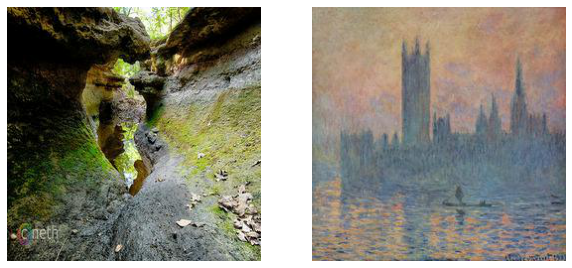

In [17]:
a,b = train_dataset[5]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

In [18]:
dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)

## Train

In [19]:
gen_A2B = ResNetGenerator().to(device)
gen_B2A = ResNetGenerator().to(device)
disc_A = PatchDiscriminator().to(device)
disc_B = PatchDiscriminator().to(device)

In [20]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen_A2B = gen_A2B.apply(weights_init)
gen_B2A = gen_B2A.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)

In [21]:
import itertools

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

#손실 함수
criterion_gan = nn.BCELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

lambda_cycle = 10
patch = (1,256//2**4,256//2**4)

n_epochs= 101
cur_epoch=0
gen_opt = torch.optim.Adam(itertools.chain(gen_A2B.parameters(), gen_B2A.parameters()),lr=0.0002,betas=(0.5,0.999))
disc_opt = torch.optim.Adam(itertools.chain(disc_A.parameters(), disc_B.parameters()),lr=0.0002,betas=(0.5,0.999))


lr_scheduler_gen = torch.optim.lr_scheduler.LambdaLR(gen_opt, lr_lambda=LambdaLR(n_epochs, cur_epoch, 100).step)
lr_scheduler_disc = torch.optim.lr_scheduler.LambdaLR(disc_opt, lr_lambda=LambdaLR(n_epochs, cur_epoch, 100).step)

In [22]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 256, 256), nrow=5, show=True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [25]:
from tqdm import tqdm_notebook
gen_A2B.train()
gen_B2A.train()
disc_A.train()
disc_B.train()

cur_step = 0
display_step = 200
g_losses = []
d_losses = []

for epoch in tqdm_notebook(range(n_epochs),desc="Training :"):
    for B, A in tqdm_notebook(dataloader,leave=False):
        cur_batch_size = len(A)
        cur_epoch +=1
        real_A = A.to(device)
        real_B = B.to(device)
        
        real_label = torch.ones(cur_batch_size,*patch,requires_grad=False).to(device)  
        fake_label = torch.zeros(cur_batch_size,*patch,requires_grad=False).to(device)

############################
        gen_opt.zero_grad()
        
        
        #GAN loss
        fake_B = gen_A2B(real_A)
        pred_fake = disc_B(fake_B)
        loss_gan_A2B = criterion_gan(pred_fake,real_label)
        
        fake_A = gen_B2A(real_B)
        pred_fake = disc_A(fake_A)
        loss_gan_B2A = criterion_gan(pred_fake,real_label)

        loss_gan = (loss_gan_A2B+loss_gan_B2A)/2

        #identity loss
        loss_id_A = criterion_identity(fake_B,real_A)
        loss_id_B = criterion_identity(fake_A,real_B)
        loss_id = (loss_id_A+loss_id_B)/2
        #cycle loss
        recovered_A = gen_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A,real_A)

        recovered_B = gen_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B,real_B)

        loss_cycle = (loss_cycle_ABA+loss_cycle_BAB)/2

        # total loss
        g_loss = loss_gan+loss_cycle*lambda_cycle+5*loss_id
        g_loss.backward()

        gen_opt.step()
        g_losses.append(g_loss)
##############################

        disc_opt.zero_grad()

        pred_real_a = disc_A(real_A)
        real_loss_a = criterion_gan(pred_real_a,real_label)

        pred_fake_a = disc_A(fake_A.detach())
        fake_loss_a = criterion_gan(pred_fake_a,fake_label)
        
        d_loss_a = (real_loss_a+fake_loss_a)/2.
        

        pred_real_b = disc_B(real_B)
        real_loss_b = criterion_gan(pred_real_b,real_label)

        pred_fake_b = disc_B(fake_B.detach())
        fake_loss_b = criterion_gan(pred_fake_b,fake_label)
        
        d_loss_b = (real_loss_b+fake_loss_b)/2.
        
        d_loss = d_loss_a+d_loss_b
        d_loss.backward()
        d_losses.append(d_loss)
        disc_opt.step()

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(g_losses[-display_step:]) / display_step
            crit_mean = sum(d_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(real_A)
            show_tensor_images(fake_B)
            show_tensor_images(real_B)
            show_tensor_images(fake_A)
            step_bins = 20
            num_examples = (len(g_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(g_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(d_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1
    lr_scheduler_disc.step()
    lr_scheduler_gen.step()

Output hidden; open in https://colab.research.google.com to view.